## Зависимостный парсинг (Dependency parsing)

Зависимостный парсинг - одна из немногих задач, где лингвистика и компьютерные науки продуктивно взаимодействуют. Основную теорию тут разрабатывают лингвисты, они же размечают корпусы, а модели построены на самых последних разробтах в области машинного обучения.

<img src="imgs/image023.png">

Так как теория и модели уже очень сложные, сделать что-то самому сопоставимого качества у вас вряд ли получится. Скорее всего вы ничего не будете обучать, а будет использовать готовые инструменты.

Два самых популярных:
    
* **Syntaxnet (DRAGNN)** — от гугла,  
* **UDPipe** — от Карлова Университета в Чехии.
    
SyntaxNet активно развивается, но его достаточно трудоёмко ставить. 
UdPipe работает похуже, но установить его легче.

Если вам нужен английский, то удобнее всего разбирать предложения через **spacy**.

Ещё есть **MaltParser**: http://www.maltparser.org/

Где прочитать про алгоритмы, если вдруг интересно:

* работа про DRAGNN: https://arxiv.org/abs/1703.04474
* работа про UDPIPE: http://www.aclweb.org/anthology/K/K17/K17-3009.pdf


Основные исследования построены на Universal Dependcies (стандарт разметки отношений, объединяющий большое количество языков).

    
Сайт Universal dependencies приводит ссылки на доступные корпуса (там уже много языков):
http://universaldependencies.org/

Пока для русского стандартный - Syntagrus:
https://github.com/UniversalDependencies/UD_Russian-SynTagRus

Скоро должен выйти большой корпус Taiga (сейчас доступна небольшая часть):
https://tatianashavrina.github.io/taiga_site/

На них можно обучать и тестрировать модели.

Большой размеченный UDPipe русскоязычный (и не только) корпус можно взять тут (острожно 24 гб в сжатом виде):
https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-1989

Вот тут описание типов отношений в UD:
http://universaldependencies.org/u/dep/

## Для чего можно использовать зависимости?

In [1]:
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph
from collections import Counter
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Посмотрим, как выглядит разобранное предложение. Я взял 50 тыс предложений из корпуса. Там много мусора, но на больших количествах это не сильно мешает.

In [2]:
sentences = open('sentences_10000.txt').read().splitlines()

In [3]:
trees = open('trees_10000.txt').read().split('\n\n')

In [4]:
# Пример предложения
sentences[1]

'приливы, нарушения сна, психологические расстройства и сухость во'

In [5]:
# Как выглядит его дерево
[x.replace('\t', ' ') for x in trees[2].split('\n')]

['1 Это это PRON _ Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing 3 nsubj _ _',
 '2 циня циня NOUN _ Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing 3 nsubj _ _',
 '3 может мочь VERB _ Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act 0 root _ _',
 '4 такой такой DET _ Case=Acc|Gender=Masc|Number=Sing 5 amod _ _',
 '5 совет совет NOUN _ Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing 3 obj _ _',
 '6 кому-то кто-то NOUN _ Animacy=Anim|Case=Dat|Gender=Masc|Number=Sing 7 obl _ _',
 '7 дать давать VERB _ Aspect=Perf|VerbForm=Inf|Voice=Act 3 xcomp _ _',
 '8 и и CCONJ _ _ 13 cc _ SpaceAfter=No',
 '9 , , PUNCT _ _ 8 punct _ _',
 '10 при при ADP _ _ 11 case _ _',
 '11 этом это PRON _ Animacy=Inan|Case=Loc|Gender=Neut|Number=Sing 13 obl _ _',
 '12 глупо глупо ADV _ Degree=Pos 13 advmod _ _',
 '13 улыбнуться улыбнуться VERB _ Aspect=Perf|VerbForm=Inf|Voice=Mid 7 conj _ SpaceAfter=No',
 '14 , , PUNCT _ _ 13 punct _ _',
 '15 думая думать VERB _ Aspect=Imp|Tense=Pres|VerbForm=Con

В nltk есть удобный класс для загрузки таких деревьев:

In [44]:
d = DependencyGraph(trees[133])

Все хранится в словаре словарей. Первый словарь - индексы слов, а дальше находится разная лингвистическая информация.

In [7]:
d.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>>,
            {0: {'address': 0,
              'ctag': 'TOP',
              'deps': defaultdict(list, {'ROOT': [], 'root': [21]}),
              'feats': None,
              'head': None,
              'lemma': None,
              'rel': None,
              'tag': 'TOP',
              'word': None},
             1: {'address': 1,
              'ctag': 'NOUN',
              'deps': defaultdict(list, {'nmod': [2]}),
              'feats': 'Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing',
              'head': 21,
              'lemma': 'привлечение',
              'rel': 'nsubj',
              'tag': '_',
              'word': 'Привлечение'},
             2: {'address': 2,
              'ctag': 'NOUN',
              'deps': defaultdict(list, {'amod': [4], 'punct': [3]}),
              'feats': 'Animacy=Anim|Case=Gen|Gender=Masc|Number=Plur',
              'head': 1,
              'lemma': 'граждани

По названию класса можно понять, что это граф. Из графа соответственно можно достать узлы и ребра.

У объекта есть метод `triples`, который достает все узлы.

In [8]:
d.root = d.nodes[0] # чтобы метод сработал нужно установить корневой элемент
list(d.triples())

[((None, 'TOP'), 'root', ('запрещается', 'VERB')),
 (('запрещается', 'VERB'), 'nsubj', ('Привлечение', 'NOUN')),
 (('Привлечение', 'NOUN'), 'nmod', ('граждан', 'NOUN')),
 (('граждан', 'NOUN'), 'punct', (',', 'PUNCT')),
 (('граждан', 'NOUN'), 'amod', ('направленных', 'VERB')),
 (('направленных', 'VERB'), 'obl', ('сборы', 'NOUN')),
 (('сборы', 'NOUN'), 'case', ('на', 'ADP')),
 (('сборы', 'NOUN'), 'amod', ('учебные', 'ADJ')),
 (('сборы', 'NOUN'), 'punct', (',', 'PUNCT')),
 (('запрещается', 'VERB'), 'obl', ('исполнению', 'NOUN')),
 (('исполнению', 'NOUN'), 'case', ('к', 'ADP')),
 (('исполнению', 'NOUN'), 'nmod', ('сборов', 'NOUN')),
 (('сборов', 'NOUN'), 'amod', ('иных', 'ADJ')),
 (('иных', 'ADJ'), 'punct', (',', 'PUNCT')),
 (('иных', 'ADJ'), 'conj', ('связанных', 'VERB')),
 (('связанных', 'VERB'), 'advmod', ('не', 'PART')),
 (('связанных', 'VERB'), 'obl', ('прохождением', 'NOUN')),
 (('прохождением', 'NOUN'), 'case', ('с', 'ADP')),
 (('сборов', 'NOUN'), 'amod', ('учебных', 'ADJ')),
 (('сб

Каждый `triple` — это набор: 

1. вершина (лемма и часть речи),
2. типа связи,
2. зависимое (тоже лемма и часть речи).

Что с этим можно сделать? Можно использовать полученные деревья для анализа корпуса. 

### Задание 1. Коллокации
Пройдитесь по корпусу, преобразуя дерево в такие же кортежи, как и в ячейке выше. Достаньте все модификаторы (отношение `advmod`) прилагательного _разный_.

In [19]:
from collections import Counter

In [26]:
modifiers = Counter()

for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0] 
    triples = list(d.triples())
    
    for head, relation, dependent in triples:
        if relation == "advmod" and "разн" in head[0]:
            modifiers.update(dependent)

In [27]:
modifiers

Counter({'ADV': 7,
         'Абсолютно': 1,
         'Тут': 1,
         'вслед': 1,
         'достаточно': 1,
         'очень': 2,
         'совершенно': 1})

Одно слова может быть недостаточно. Отношение часто указывает на главное слово в какой-то именной группе, а от него отходят отношения к другим её составляющим. Мы можем захотеть пройтись по всем ответвлениям, чтобы собрать всю именную группу. Удобнее всего это сделать через рекурсию. Напишем функцию, которая проходит по всем зависимым конкретного узла в дереве и достаёт их зависимые, пока не упрется в терминальный узел.

In [58]:
def get_subtree(nodes, node):
    if not nodes[node]['deps']:
        return [node]
    else:
        return [node] + [get_subtree(nodes, dep) for rel in nodes[node]['deps']
                         if rel != 'punct' 
                         for dep in nodes[node]['deps'][rel]]

Посмотрим на дерево.

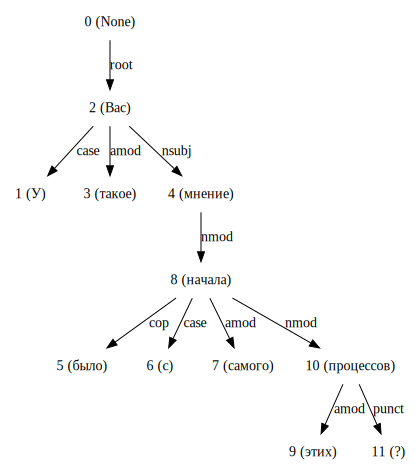

In [46]:
d

Достанем все поддерево какого-нибудь элемента.

In [48]:
get_subtree(d.nodes, 0)

[0, [2, [1], [3], [4, [8, [5], [6], [7], [10, [9]]]]]]

Получается список с вложенными списками. Чтобы представить это все в читаемом формате лучше его раплющить ещё одной рекурсивной функцией. 

In [49]:
def flatten(l):
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat

In [50]:
flatten(get_subtree(d.nodes, 0))

[0, 2, 1, 3, 4, 8, 5, 6, 7, 10, 9]

Проверим, что досталось.

In [53]:
[d.nodes[i]['word'] for i in flatten(get_subtree(d.nodes, 0))]

[None,
 'Вас',
 'У',
 'такое',
 'мнение',
 'начала',
 'было',
 'с',
 'самого',
 'процессов',
 'этих']

Нужно ещё восстановить порядок.

In [54]:
[d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 0)))]

[None,
 'У',
 'Вас',
 'такое',
 'мнение',
 'было',
 'с',
 'самого',
 'начала',
 'этих',
 'процессов']

In [55]:
[d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 10)))]

['этих', 'процессов']

### Задание 2. Open Information Extraction

Попробуйте теперь также пройтись по корпусу, найти глаголы и если у этих глаголов есть **nsubj** и **obj** (или **obl**), то достать всё поддерево для них. Результат должен выглядеть как-то так:
```python    
('Субъект', 'глагол', 'объект')```

Такая задача называется **Open Information Extraction**.

In [56]:
# доделать позже!

### Использование для других задач

Ещё зависимости можно использовать в качестве признаков для классификации или кластеризации.

Допустим мы хотим научиться выделять отношения между существительными. Мы можем пройтись по корпусу, достать все фразы, а потом достать из графа самый короткий путь, соединящию эти фразы.

Дальше путь можно каким-то образом преобразовать в векторы и напрмую засовывать в классификатор или кластеризатор. 

In [59]:
# поиск самого короткого пути есть в networkx
import networkx as nx

In [60]:
dg = DependencyGraph(trees[123])
edges = []

for e in dg.nodes:
    for dep in dg.nodes[e]['deps']:
        for t in dg.nodes[e]['deps'][dep]:
            edges.append((e, t))

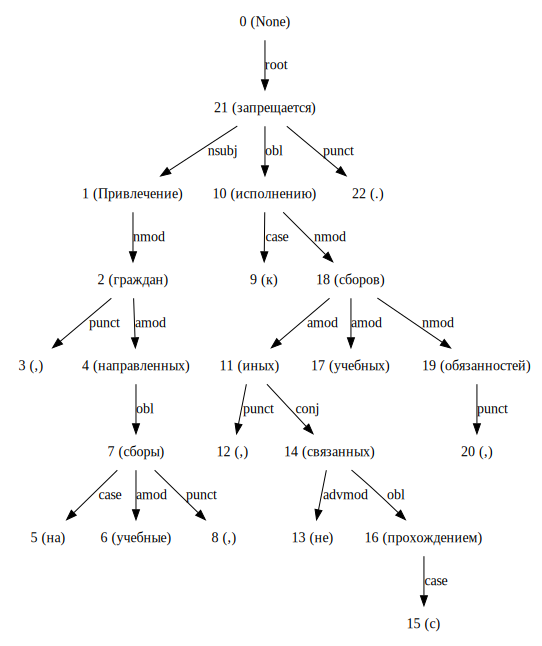

In [61]:
dg

In [62]:
edges

[(0, 21),
 (1, 2),
 (21, 1),
 (21, 10),
 (21, 22),
 (2, 3),
 (2, 4),
 (4, 7),
 (7, 5),
 (7, 6),
 (7, 8),
 (10, 9),
 (10, 18),
 (11, 12),
 (11, 14),
 (18, 11),
 (18, 17),
 (18, 19),
 (14, 13),
 (14, 16),
 (16, 15),
 (19, 20)]

In [63]:
graph = nx.Graph()
graph.add_edges_from(ebunch=edges)

TypeError: add_edges_from() missing 1 required positional argument: 'ebunch_to_add'

In [40]:
nx.shortest_path(graph, 1, 10)

[1, 21, 10]

Ещё с помощью деревьев завимимостей можно находить похожие по структуре предложения. Похожесть графов не тривиальная проблема, но кое-что готовое есть.

Например, есть библиотека zss (https://github.com/timtadh/zhang-shasha), которая реализует алгоритм редактирования деревьев (примерно как с Левенштейном, но с учетом структуры дерева).

По умолчанию разница высчитывается на основе расстояния между названиями узлов и для своих задач её лучше переопределить.

In [64]:
import zss
import re

In [65]:
# эта функция достает поддерво элементов c дополнительной информацией 
# и возвращает всё в нужном zss формате

def subtree(node, tree):
    if not tree[node]['deps']:
        word = tree[node]['word'].replace("'", '"')
        
        if not word:
            word = 'UNK'
        pos = tree[node]['ctag'].replace("'", '"')
        rel = tree[node]['rel'].replace("'", '"')
        label = 'WORD=#{}#,POS=#{}#,REL=#{}#'.format(word, pos, rel)
        return "WNode('{}', [])".format(label)
    else:
        sub = []
        for dep in tree[node]['deps']:
            for n in tree[node]['deps'][dep]:
                sub.append(subtree(n, tree))
        
        if not tree[node]['rel']:
            if tree[node]['ctag'] == 'TOP':
                name = 'TOP'
                word = 'TOP'
                if not word:
                    word = 'UNK'
                pos = 'TOP'
                rel = 'TOP'
            else:
                print('Node numeber - {} is None and not TOP!'.format(node))
                raise KeyError
        else:    
            word = tree[node]['word'].replace("'", '"')
            pos = tree[node]['ctag'].replace("'", '"')
            rel = tree[node]['rel'].replace("'", '"')
        label = 'WORD=#{}#,POS=#{}#,REL=#{}#'.format(word, pos, rel)
            
        return "WNode('{}', [{}])".format(label , ', '.join(sub))


# функция раастояния для деревьев

def weird_dist(A, B):
    ma = re.search('WORD=#(.*?)#,POS=#(.*?)#,REL=#(.*?)#', A)
    mb = re.search('WORD=#(.*?)#,POS=#(.*?)#,REL=#(.*?)#', B)
    
    # для удаления 
    if not ma and mb: # сколько стоит добавление узла
        return 1
    elif ma and not mb: # сколько стоит удаление узла
        return 3
    elif not ma and not mb:
        return 0
    
    # для расчета расстояния можно учитывать само слов
    # часть речи, отношение и любую другую информацию
    
    word_a, pos_a, rel_a = ma.groups()
    word_b, pos_b, rel_b = mb.groups()
    
    
    dist = 0
    
    
    if word_a != word_b:
        dist += 1
    
    if pos_a != pos_b:
        dist += 1
    
    if rel_a != rel_b:
        dist += 1
    
    
    return dist

# специальный класс для zss
class WNode(object):

    def __init__(self, label, children=None):
        self.my_label = label
        self.my_children = children or list()

    @staticmethod
    def get_children(node):
        return node.my_children

    @staticmethod
    def get_label(node):
        return node.my_label

    def addkid(self, node, before=False):
        if before:  self.my_children.insert(0, node)
        else:   self.my_children.append(node)
        return self
    
    def __str__(self):
        s = "%d:%s" % (len(self.my_children), self.my_label)
        s = '\n'.join([s]+[str(c) for c in self.my_children])
        return s



In [66]:
A = eval(subtree(0, DependencyGraph(trees[123]).nodes))
B = eval(subtree(0, DependencyGraph(trees[1223]).nodes))
print(zss.simple_distance(A, B, WNode.get_children, 
                                   WNode.get_label, weird_dist))

64.0


Посравниваем деревья.

In [67]:
distances = []
for i in range(0, 500):
    
    
    try:
        A = eval(subtree(0, DependencyGraph(trees[i]).nodes))
        print(i)
        for j in np.random.choice(range(len(trees)), 100):
            B = eval(subtree(0, DependencyGraph(trees[j]).nodes))
            dist = zss.simple_distance(A, B, WNode.get_children, 
                                       WNode.get_label, weird_dist)
            distances.append((i, j, dist))
    except TypeError:
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


AttributeError: 'NoneType' object has no attribute 'replace'

Посмотрим, что нашлось.

In [29]:
sorted(distances, key=lambda x: x[2])

[(15, 1650, 4),
 (9, 4266, 9),
 (9, 4475, 10),
 (8, 9900, 11),
 (12, 7518, 12),
 (12, 5314, 12),
 (8, 2057, 13),
 (9, 9140, 13),
 (9, 574, 13),
 (9, 345, 13),
 (9, 4910, 13),
 (11, 289, 13),
 (11, 6703, 13),
 (12, 6059, 13),
 (12, 5968, 13),
 (15, 4550, 13),
 (8, 731, 14),
 (8, 9636, 14),
 (9, 7226, 14),
 (9, 4726, 14),
 (9, 9642, 14),
 (12, 3159, 14),
 (12, 9525, 14),
 (12, 4400, 14),
 (12, 3131, 14),
 (12, 6514, 14),
 (12, 8610, 14),
 (12, 3597, 14),
 (12, 1985, 14),
 (12, 5626, 14),
 (12, 498, 14),
 (13, 4704, 14),
 (13, 8437, 14),
 (15, 8353, 14),
 (8, 4928, 15),
 (8, 8748, 15),
 (8, 7687, 15),
 (8, 5599, 15),
 (8, 9999, 15),
 (8, 2796, 15),
 (9, 6619, 15),
 (9, 5444, 15),
 (9, 6661, 15),
 (9, 4113, 15),
 (9, 5631, 15),
 (9, 9926, 15),
 (9, 6038, 15),
 (11, 5683, 15),
 (11, 6328, 15),
 (11, 4687, 15),
 (12, 9114, 15),
 (12, 9735, 15),
 (12, 1145, 15),
 (12, 6469, 15),
 (12, 6275, 15),
 (12, 3533, 15),
 (12, 7770, 15),
 (12, 467, 15),
 (7, 8454, 16),
 (8, 1196, 16),
 (8, 6189, 16),


In [26]:

[x.replace('\t', ' ') for x in trees[0].split('\n')]

['1 Панихиду Панихида VERB _ Aspect=Perf|Mood=Ind|Number=Sing|Person=1|Tense=Fut|VerbForm=Fin|Voice=Act 0 root _ _',
 '2 по по ADP _ _ 3 case _ _',
 '3 жертвам жертва NOUN _ Animacy=Anim|Case=Dat|Gender=Fem|Number=Plur 1 obl _ _',
 '4 трагедии трагедия NOUN _ Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing 3 nmod _ SpaceAfter=No',
 '5 , , PUNCT _ _ 4 punct _ _',
 '6 произошедшей произоходить VERB _ Aspect=Perf|Case=Loc|Gender=Fem|Number=Sing|Tense=Past|VerbForm=Part|Voice=Act 3 amod _ _',
 '7 в в ADP _ _ 8 case _ _',
 '8 Одессе одесса PROPN _ Animacy=Inan|Case=Loc|Gender=Fem|Number=Sing 6 obl _ _',
 '9 2 2 NUM _ _ 6 nummod _ _',
 '10 мая май NOUN _ Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing 9 nmod _ SpaceAfter=No',
 '11 , , PUNCT _ _ 10 punct _ _',
 '12 отслужили отслуживать VERB _ Aspect=Perf|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act 1 parataxis _ _',
 '13 в в ADP _ _ 14 case _ _',
 '14 воскресенье воскресенье NOUN _ Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing 12 obl _ 

In [27]:
# Как выглядит его дерево
[x.replace('\t', ' ') for x in trees[9371].split('\n')]

['1 ЗАСО ЗАСО ADP _ _ 3 case _ _',
 '2 " " PUNCT _ _ 3 punct _ SpaceAfter=No',
 '3 Белнефтестрах Белнефтестра PROPN _ Animacy=Inan|Case=Loc|Gender=Fem|Number=Plur 0 root _ SpaceAfter=No',
 '4 " " PUNCT _ _ 3 punct _ _',
 '5 - - PUNCT _ _ 3 punct _ _',
 '6 Высококачественное высококачественный ADJ _ Case=Nom|Degree=Pos|Gender=Neut|Number=Sing 7 amod _ _',
 '7 страхование страхование NOUN _ Animacy=Inan|Case=Nom|Gender=Neut|Number=Sing 3 parataxis _ _',
 '8 для для ADP _ _ 12 case _ _',
 '9 физических физический ADJ _ Case=Gen|Degree=Pos|Number=Plur 12 amod _ _',
 '10 и и CCONJ _ _ 11 cc _ _',
 '11 юридических юридический ADJ _ Case=Gen|Degree=Pos|Number=Plur 9 conj _ _',
 '12 лиц лицо NOUN _ Animacy=Anim|Case=Gen|Gender=Neut|Number=Plur 7 nmod _ _',
 '13 в в ADP _ _ 14 case _ _',
 '14 Беларуси Беларусь PROPN _ Animacy=Inan|Case=Loc|Gender=Fem|Number=Sing 12 nmod _ _']

In [58]:
WNode('WORD=#TOP#,POS=#TOP#,REL=#TOP#', [WNode('WORD=#презентовала#,POS=#VERB#,REL=#root#', [WNode('WORD=#Компания#,POS=#PROPN#,REL=#nsubj#', [WNode('WORD=#ИНТРА»#,POS=#PROPN#,REL=#flat:name#', []), WNode('WORD=#«Сервисная#,POS=#ADJ#,REL=#amod#', [])]), WNode('WORD=#21#,POS=#NUM#,REL=#nummod#', [WNode('WORD=#-#,POS=#PUNCT#,REL=#punct#', []), WNode('WORD=#июня#,POS=#NOUN#,REL=#nmod#', [WNode('WORD=#ООО#,POS=#PROPN#,REL=#nmod#', [])]), WNode('WORD=#22#,POS=#NUM#,REL=#nummod#', [])]), WNode('WORD=#технологии#,POS=#NOUN#,REL=#obj#', [WNode('WORD=#ремонта#,POS=#NOUN#,REL=#nmod#', [WNode('WORD=#композитного#,POS=#ADJ#,REL=#amod#', [])]), WNode('WORD=#конференции#,POS=#NOUN#,REL=#nmod#', [WNode('WORD=#на#,POS=#ADP#,REL=#case#', []), WNode('WORD=#ТРУБОПРОВОДЫ#,POS=#PROPN#,REL=#appos#', [WNode('WORD=#'2016#,POS=#X#,REL=#flat:foreign#', []), WNode('WORD=#ПРОМЫСЛОВЫЕ#,POS=#ADJ#,REL=#amod#', [])]), WNode('WORD=#5-ой#,POS=#ADJ#,REL=#amod#', []), WNode('WORD=#Ежегодной#,POS=#ADJ#,REL=#amod#', []), WNode('WORD=#технической#,POS=#ADJ#,REL=#amod#', [WNode('WORD=#производственно#,POS=#ADJ#,REL=#compound#', [WNode('WORD=#-#,POS=#PUNCT#,REL=#punct#', [])])])])])])])

In [59]:
dist

66

In [156]:
import gensim

In [159]:
sents = []
for tree in trees:
    try:
        words = [x.split('\t')[1] for x in tree.split('\n')]
    except:
        continue
    sents.append(words)

In [160]:
sents[:10]

[['Естественно', 'цена', 'там', 'была', 'аховая', '.'],
 ['–', 'Может', '.', '.', '.'],
 ['Когда',
  'у',
  'вас',
  'появляется',
  'нагрузка',
  ',',
  'которую',
  'нужно',
  'оптимизировать',
  '—',
  'php',
  '/',
  'ruby/python',
  'становятся',
  'убогими',
  '.'],
 ['Турецкий',
  'сериал',
  'Серебро',
  '/',
  'Гюмюш',
  '/',
  'Gümüş',
  '61',
  'серия',
  'онлайн',
  'с',
  'русскими',
  'субтитрами'],
 ['Подхалимство',
  'и',
  'его',
  'неизбежное',
  'следствие',
  '-',
  'очковтирательство',
  'могут',
  '.'],
 ['См.',
  'похожие',
  'отели',
  'Belltown',
  'Inn',
  '798',
  'отзывовПоказать',
  'цены',
  '0.3',
  'км',
  'Hotel',
  'Five',
  '-',
  'A',
  'Piece',
  'of',
  'Pineapple',
  'Hospitality',
  '1',
  '064',
  'отзываПоказать',
  'цены',
  '0.6',
  'км',
  'The',
  'Edgewater',
  ',',
  'A',
  'Noble',
  'House',
  'Hotel',
  '3',
  '279',
  'отзывовПоказать',
  'цены',
  '0.3',
  'км',
  'Сиэтл',
  ':',
  'просмотреть',
  'все',
  'отели',
  'Интересное',
 